https://pytorch.org/audio/stable/tutorials/mvdr_tutorial.html

In [15]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cpu
2.0.2+cpu


In [16]:
# When running this example in notebook, install the following packages.
# !pip3 install mir_eval
# !pip3 install pesq
# !pip3 install pystoi
from pesq import pesq
from pystoi import stoi
import mir_eval

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

In [28]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = "speech_9.wav"
SAMPLE_NOISE = "Alpha0.60.wav"

In [29]:
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()


def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [30]:
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE

In [31]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

The STOI score is a value between 0 and 1, where 0 represents no intelligibility (completely unintelligible) and 1 represents perfect intelligibility (no degradation, the speech is fully understandable).

The estimated quality of a degraded speech signal compared to a reference (original) speech signal. PESQ scores typically fall within a specific range, and their interpretation can vary based on this range.

In the PESQ scale, the scores generally range from approximately -0.5 to 4.5, with specific meanings attributed to different score ranges:

Scores above 4.0: Excellent quality. The degraded speech is very close to the reference, and the quality is perceived as excellent.

Scores between 3.5 and 4.0: Good quality. The degraded speech is of high quality and retains most of the characteristics of the reference.

Scores between 2.0 and 3.5: Fair to acceptable quality. The degraded speech is intelligible but may have noticeable quality issues.

Scores below 2.0: Poor quality. The degraded speech has significant quality issues, and it may be challenging to understand.

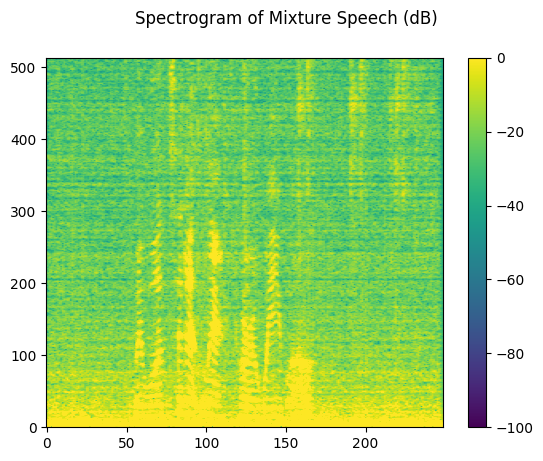

SDR score: -1.1227649709838343
Si-SNR score: -1.6036186218261719
PESQ score: 1.1152722835540771
STOI score: 0.6844300805053516


In [32]:
plot_spectrogram(stft_noise[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_noise[0:1], waveform_clean[0:1])
Audio(waveform_noise[0], rate=SAMPLE_RATE)

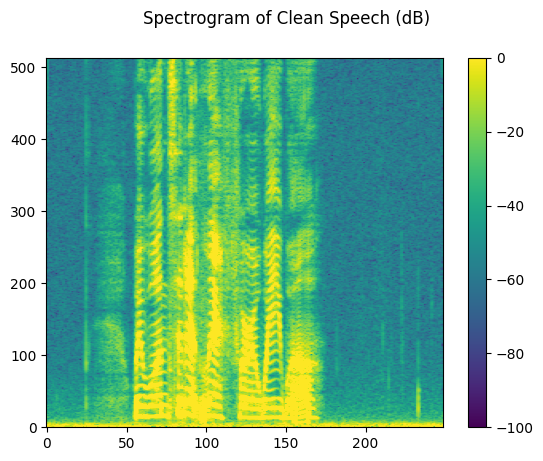

In [43]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)